### RankFM with Features Comparison

In [1]:

import numpy as np
import numba as nb
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from rankfm.rankfm import RankFM
from rankfm.evaluation import hit_rate, reciprocal_rank, discounted_cumulative_gain, precision, recall, diversity

import warnings
# warnings.filterwarnings("ignore", category=nb.NumbaPerformanceWarning)

#### Load Interactions Data

In [2]:
interactions = pd.read_csv("ml-1m/ratings.dat", names=["user_id", "item_id", "rating", "timestamp"], delimiter="::", engine="python")
interactions.head()

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


#### Load User Features

In [3]:
user_features = pd.read_csv("ml-1m/users.dat", names=["user_id", "gender", "age", "occupation", "zipcode"], delimiter="::", engine="python")
user_features = user_features.drop('zipcode', axis=1)
user_features.occupation = user_features.occupation.astype('str')
user_features.age = user_features.age.astype('str')
user_features = pd.get_dummies(user_features)

user_features.head()

,user_id,gender_F,gender_M,age_1,age_18,age_25,age_35,age_45,age_50,age_56,...,occupation_19,occupation_2,occupation_20,occupation_3,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9
0,1,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,3,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,5,False,True,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


#### Load Item Features

In [4]:
import collections

movie_desc = pd.read_csv("ml-1m/movies.dat", names=["item_id", "title", "genres"], delimiter="::", engine="python", encoding="ISO-8859-1")

# Convert genres to lowercase
movie_desc.genres = movie_desc.genres.str.lower()

split_series = movie_desc.genres.str.split('|').apply(lambda x: x)
split_series_dict = split_series.apply(collections.Counter)

multi_hot = pd.DataFrame.from_records(split_series_dict).fillna(value=0).astype('int')

item_features = pd.concat([movie_desc.item_id, multi_hot], axis=1)
item_features

,item_id,animation,children's,comedy,adventure,fantasy,romance,drama,action,crime,thriller,horror,sci-fi,documentary,war,musical,mystery,film-noir,western
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3879,3949,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3880,3950,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3881,3951,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


#### Load Item Names
* these won't be used for model fitting, but are important when reviewing the output for face validity
* also analyzing recommended/similar movies isn't any fun if you can't see the titles!

In [5]:
item_names = movie_desc
item_names.head()

,item_id,title,genres
0,1,Toy Story (1995),animation|children's|comedy
1,2,Jumanji (1995),adventure|children's|fantasy
2,3,Grumpier Old Men (1995),comedy|romance
3,4,Waiting to Exhale (1995),comedy|drama
4,5,Father of the Bride Part II (1995),comedy


#### Evaluate Interaction Matrix Sparsity

In [6]:
unique_users = interactions.user_id.nunique()
unique_items = interactions.item_id.nunique()

sparsity = 1 - (len(interactions) / (unique_users * unique_items))
print("interaction matrix sparsity: {}%".format(round(100 * sparsity, 1)))

interaction matrix sparsity: 95.5%


#### Split Interactions Data into (Train, Valid) for Model Evaluation
* we'll randomly split off 25% of the observed user/item interactions for model validation
* take care to note any users/items in the validation set not appearing in the training set
* for model fitting we'll have to unify the set of users/items across `interactions`, `user_features`, `item_features`
* for scoring/recommendation RankFM has the `cold_start` option to either drop unseen users/items or set model output to np.nan

In [7]:
np.random.seed(42)
interactions['random'] = np.random.random(size=len(interactions))
test_pct = 0.25

In [8]:
train_mask = interactions['random'] <  (1 - test_pct)
valid_mask = interactions['random'] >= (1 - test_pct)

interactions_train = interactions[train_mask][['user_id', 'item_id']]
interactions_valid = interactions[valid_mask][['user_id', 'item_id']]

train_users = np.sort(interactions_train.user_id.unique())
valid_users = np.sort(interactions_valid.user_id.unique())
cold_start_users = set(valid_users) - set(train_users)

train_items = np.sort(interactions_train.item_id.unique())
valid_items = np.sort(interactions_valid.item_id.unique())
cold_start_items = set(valid_items) - set(train_items)

print("train shape: {}".format(interactions_train.shape))
print("valid shape: {}".format(interactions_valid.shape))

print("train users: {}".format(len(train_users)))
print("valid users: {}".format(len(valid_users)))
print("cold-start users: {}".format(cold_start_users))

print("train items: {}".format(len(train_items)))
print("valid items: {}".format(len(valid_items)))
print("cold-start items: {}".format(cold_start_items))

train shape: (750042, 2)
valid shape: (250167, 2)
train users: 6040
valid users: 6040
cold-start users: set()
train items: 3670
valid items: 3507
cold-start items: {3842, 2308, 2438, 3220, 3607, 2584, 1820, 2845, 2591, 545, 1316, 2214, 1832, 1579, 3376, 1714, 1843, 2226, 2742, 311, 826, 2235, 3517, 1470, 576, 2895, 601, 3291, 989, 1630, 2909, 868, 2277, 2039, 3065, 2556}


Note:
* All user in valid are exists in training data
* There are items in valid that no exists in training data

In [9]:
user_features = user_features[user_features.user_id.isin(train_users)]
item_features = item_features[item_features.item_id.isin(train_items)]
user_features.shape, item_features.shape

((6040, 31), (3670, 19))

In [10]:
df_train = interactions[['user_id', 'item_id']]
df_train_total = df_train.groupby('user_id')['item_id'].count().reset_index(name="total_item")
df_train_total

,user_id,total_item
0,1,53
1,2,129
2,3,51
3,4,21
4,5,198
...,...,...
6035,6036,888
6036,6037,202
6037,6038,20
6038,6039,123


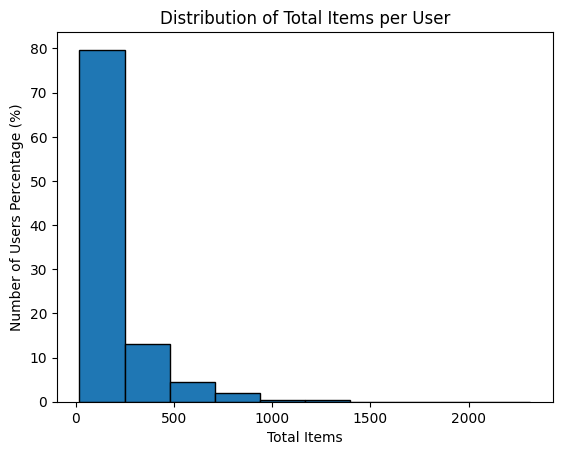

In [11]:
import matplotlib.pyplot as plt

total_users = len(df_train_total)

# Create a histogram
plt.hist(df_train_total['total_item'], bins=10, edgecolor='black', weights=np.ones(total_users) / total_users * 100)
plt.title('Distribution of Total Items per User')
plt.xlabel('Total Items')
plt.ylabel('Number of Users Percentage (%)')
plt.show()

In [12]:
# Define the bins
bins = [0, 10, 100, 500, np.inf]

# Define the labels for the bins
labels = ['0-10', '11-100', '101-500', '500+']

# Create a new column for the total_item ranges
df_train_total['total_item_range'] = pd.cut(df_train_total['total_item'], bins=bins, labels=labels)
df_train_total_sorted = df_train_total.sort_values(by='total_item_range')

# Print the DataFrame to check the result
print(df_train_total_sorted)

      user_id  total_item total_item_range
0           1          53           11-100
2504     2505          32           11-100
4798     4799          58           11-100
2507     2508          60           11-100
2508     2509          41           11-100
...       ...         ...              ...
1850     1851         504             500+
4276     4277        1743             500+
2664     2665         828             500+
3223     3224        1115             500+
4015     4016         678             500+

[6040 rows x 3 columns]


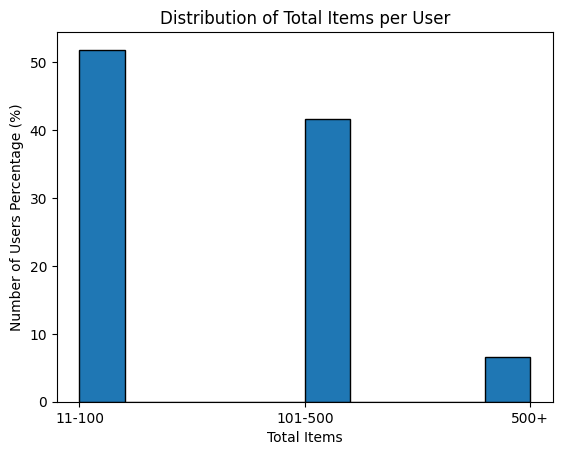

In [13]:
# Create a histogram
plt.hist(df_train_total_sorted['total_item_range'], bins=10, edgecolor='black', weights=np.ones(total_users) / total_users * 100)
plt.title('Distribution of Total Items per User')
plt.xlabel('Total Items')
plt.ylabel('Number of Users Percentage (%)')
plt.show()

### Fit the Model on the Training Data and Evaluate Out-of-Sample Performance Metrics

#### Initialize the Model Object

In [14]:
model = RankFM(factors=20, loss='warp', max_samples=20, alpha=0.01, sigma=0.1, learning_rate=0.10)
model

#### Fit the Model on the Training Data
* each epoch represents one full pass through all observed user/item interactions in the training data
* the `verbose` flag will print the current training epoch as well as the epoch's penalized log-likelihood value
* the training algorithm attempts to maximize the model's log likelihood which represents user preferences for observed items over unobserved items
* the log likelihood isn't 1:1 correlated with our recommendation/ranking evaluation metrics but serves as a decent proxy for training progress 

In [15]:
%%time
model.fit(interactions=interactions_train, epochs=100, verbose=True)


training epoch: 0
log likelihood: -433697.3125

training epoch: 1
log likelihood: -421315.71875

training epoch: 2
log likelihood: -414566.65625

training epoch: 3
log likelihood: -411272.25

training epoch: 4
log likelihood: -409628.75

training epoch: 5
log likelihood: -408434.09375

training epoch: 6
log likelihood: -407527.1875

training epoch: 7
log likelihood: -406857.34375

training epoch: 8
log likelihood: -407042.46875

training epoch: 9
log likelihood: -406293.875

training epoch: 10
log likelihood: -406154.28125

training epoch: 11
log likelihood: -406240.125

training epoch: 12
log likelihood: -406080.90625

training epoch: 13
log likelihood: -405879.53125

training epoch: 14
log likelihood: -405891.625

training epoch: 15
log likelihood: -405619.78125

training epoch: 16
log likelihood: -405918.1875

training epoch: 17
log likelihood: -405949.4375

training epoch: 18
log likelihood: -406232.53125

training epoch: 19
log likelihood: -406024.46875

training epoch: 20
log li

#### Generate Model Scores for Validation Interactions
* the `predict()` method generates real-valued model scores for user/item pairs
* specify scoring interactions or user/item pairs the same way as training: `[user_id, item_id]`
* the scores generated are those produced by the underlying second-degree factorization machine model
* the `cold_start` option allows you to either generate missing values for unseen users/items or drop them from scoring output

In [16]:
valid_scores = model.predict(interactions_valid, cold_start='nan') 
print(valid_scores.shape)
pd.Series(valid_scores).describe()

(250167,)


count    250128.000000
mean          0.755314
std           0.996049
min          -4.613097
25%           0.061935
50%           0.738961
75%           1.448873
max           4.743924
dtype: float64

#### Generate TopN Recommendations for Validation Users
* instead of having to generate predictions for all user/item pairs the `recommend()` method lets you generate the topN recommended items for each user
* the output is a pd.dataframe where the index values are `user_id` and the columns are recommended items in descending order (first column is best item)
* additionally there's an option `filter_previous` to exclude any items already observed during training for the user from being recommended
* as with `predict()` there's a `cold_start` option to either fill with missing or drop recommendations for any user not found in training

In [17]:
valid_recommendations = model.recommend(valid_users, n_items=10, filter_previous=False, cold_start='nan')
valid_recommendations.head()

,0,1,2,3,4,5,6,7,8,9
1,595,2018,594,2396,588,1270,919,2081,527,2085
2,2028,349,1610,1196,318,110,2353,3256,457,2396
3,1270,1291,2918,1259,1196,1210,2174,589,2028,1198
4,1196,260,1214,1221,1210,1291,1222,1387,3702,858
5,2692,2336,2908,2959,2599,2762,2396,2997,2712,2858


In [18]:
k = 10

# transform interactions into a user -> items dictionary
test_user_items = interactions_valid.groupby('user_id')['item_id'].apply(set).to_dict()
test_users = list(test_user_items.keys())

# generate topK recommendations for all test users also present in the training data
test_recs = model.recommend(users=test_users, n_items=k, filter_previous=False, cold_start='drop')
comm_user = test_recs.index.values

#### Evaluate Model Performance on the Validation Data

##### Specify Number of Recommended Items
* here we'll look at model performance in terms of validation metrics wrt the top 10 recommended items for each user
* it's good to compare validation metrics against the best unpersonalized recommendations: overall item popularity rankings from the training data

In [19]:
k = 10

##### Generate Pure-Popularity Baselines

In [20]:
most_popular = interactions_train.groupby('item_id')['user_id'].count().sort_values(ascending=False)[:k]
most_popular

item_id
2858    2575
1196    2240
260     2223
1210    2162
2028    2019
589     1996
480     1994
2571    1969
593     1927
1270    1917
Name: user_id, dtype: int64

In [21]:
test_user_items = interactions_valid.groupby('user_id')['item_id'].apply(set).to_dict()
test_user_items = {key: val for key, val in test_user_items.items() if key in set(train_users)}

base_hrt = np.mean([int(len(set(most_popular.index) & set(val)) > 0) for key, val in test_user_items.items()])
base_pre = np.mean([len(set(most_popular.index) & set(val)) / len(set(most_popular.index)) for key, val in test_user_items.items()])
base_rec = np.mean([len(set(most_popular.index) & set(val)) / len(set(val)) for key, val in test_user_items.items()])

print("number of test users: {}".format(len(test_user_items)))
print("baseline hit rate: {:.3f}".format(base_hrt))
print("baseline precision: {:.3f}".format(base_pre))
print("baseline recall: {:.3f}".format(base_rec))

number of test users: 6040
baseline hit rate: 0.634
baseline precision: 0.116
baseline recall: 0.045


##### Generate Model Validation Metrics
* the RankFM package comes with a number of utility functions to evaluate model performance
* these functions cover common validation metrics for recommendation/ranking models with implicit feedback data
* all evaluation functions have the same interface and require a previously fit RankFM model
    * `hit_rate`: the proportion of users with any relevant recommended item
    * `reciprocal_rank`: the inverse rank of the first relevant recommended item (or zero if no matches)
    * `discounted_cumulative_gain`: the sum of the inverse log-scaled ranks for relevant recommended items
    * `precision`: the number of relevant recommended items / number of recommended items
    * `recall`: the number of relevant recommended items / number of relevant items

In [22]:
%%time
model_hit_rate = hit_rate(model, interactions_valid, k=k)
model_reciprocal_rank = reciprocal_rank(model, interactions_valid, k=k)
model_dcg = discounted_cumulative_gain(model, interactions_valid, k=k)
model_precision = precision(model, interactions_valid, k=k)
model_recall = recall(model, interactions_valid, k=k)

CPU times: user 11.8 s, sys: 0 ns, total: 11.8 s
Wall time: 11.8 s


In [23]:
print("hit_rate: {:.3f}".format(model_hit_rate))
print("reciprocal_rank: {:.3f}".format(model_reciprocal_rank))
print("dcg: {:.3f}".format(model_dcg, 3))
print("precision: {:.3f}".format(model_precision))
print("recall: {:.3f}".format(model_recall))

hit_rate: 0.787
reciprocal_rank: 0.339
dcg: 0.722
precision: 0.156
recall: 0.072


#### Evaluate with users and item features separate training 


In [24]:
%%time
model.fit(interactions=interactions_train, user_features=user_features, epochs=20, verbose=True)

model_hit_rate = hit_rate(model, interactions_valid, k=k)
model_reciprocal_rank = reciprocal_rank(model, interactions_valid, k=k)
model_dcg = discounted_cumulative_gain(model, interactions_valid, k=k)
model_precision = precision(model, interactions_valid, k=k)
model_recall = recall(model, interactions_valid, k=k)



training epoch: 0
log likelihood: -440354.46875

training epoch: 1
log likelihood: -431471.1875

training epoch: 2
log likelihood: -428084.34375

training epoch: 3
log likelihood: -426394.40625

training epoch: 4
log likelihood: -425102.78125

training epoch: 5
log likelihood: -423962.03125

training epoch: 6
log likelihood: -422966.40625

training epoch: 7
log likelihood: -423084.59375

training epoch: 8
log likelihood: -423222.65625

training epoch: 9
log likelihood: -422458.1875

training epoch: 10
log likelihood: -422695.125

training epoch: 11
log likelihood: -422492.65625

training epoch: 12
log likelihood: -422401.09375

training epoch: 13
log likelihood: -422310.75

training epoch: 14
log likelihood: -422140.5

training epoch: 15
log likelihood: -421908.71875

training epoch: 16
log likelihood: -422218.65625

training epoch: 17
log likelihood: -422015.03125

training epoch: 18
log likelihood: -422436.15625

training epoch: 19
log likelihood: -421982.09375
CPU times: user 53.2 

In [25]:
print("hit_rate: {:.3f}".format(model_hit_rate))
print("reciprocal_rank: {:.3f}".format(model_reciprocal_rank))
print("dcg: {:.3f}".format(model_dcg, 3))
print("precision: {:.3f}".format(model_precision))
print("recall: {:.3f}".format(model_recall))

hit_rate: 0.776
reciprocal_rank: 0.334
dcg: 0.706
precision: 0.152
recall: 0.070


In [26]:
%%time
model.fit(interactions=interactions_train, item_features=item_features, epochs=20, verbose=True)

model_hit_rate = hit_rate(model, interactions_valid, k=k)
model_reciprocal_rank = reciprocal_rank(model, interactions_valid, k=k)
model_dcg = discounted_cumulative_gain(model, interactions_valid, k=k)
model_precision = precision(model, interactions_valid, k=k)
model_recall = recall(model, interactions_valid, k=k)


training epoch: 0
log likelihood: -434000.90625

training epoch: 1
log likelihood: -424978.59375

training epoch: 2
log likelihood: -422064.25

training epoch: 3
log likelihood: -420227.53125

training epoch: 4
log likelihood: -419009.40625

training epoch: 5
log likelihood: -417981.90625

training epoch: 6
log likelihood: -416937.65625

training epoch: 7
log likelihood: -416999.0

training epoch: 8
log likelihood: -417281.15625

training epoch: 9
log likelihood: -416974.1875

training epoch: 10
log likelihood: -416674.125

training epoch: 11
log likelihood: -416708.625

training epoch: 12
log likelihood: -416794.09375

training epoch: 13
log likelihood: -416715.90625

training epoch: 14
log likelihood: -416474.6875

training epoch: 15
log likelihood: -416480.40625

training epoch: 16
log likelihood: -416451.9375

training epoch: 17
log likelihood: -416536.90625

training epoch: 18
log likelihood: -416365.1875

training epoch: 19
log likelihood: -416504.03125
CPU times: user 46.1 s, s

In [27]:
print("hit_rate: {:.3f}".format(model_hit_rate))
print("reciprocal_rank: {:.3f}".format(model_reciprocal_rank))
print("dcg: {:.3f}".format(model_dcg, 3))
print("precision: {:.3f}".format(model_precision))
print("recall: {:.3f}".format(model_recall))

hit_rate: 0.771
reciprocal_rank: 0.329
dcg: 0.698
precision: 0.150
recall: 0.069


In [28]:
%%time
model.fit(interactions=interactions_train, user_features=user_features, item_features=item_features, epochs=20, verbose=True)

model_hit_rate = hit_rate(model, interactions_valid, k=k)
model_reciprocal_rank = reciprocal_rank(model, interactions_valid, k=k)
model_dcg = discounted_cumulative_gain(model, interactions_valid, k=k)
model_precision = precision(model, interactions_valid, k=k)
model_recall = recall(model, interactions_valid, k=k)


training epoch: 0
log likelihood: -441367.09375

training epoch: 1
log likelihood: -436564.09375

training epoch: 2
log likelihood: -435837.75

training epoch: 3
log likelihood: -435708.28125

training epoch: 4
log likelihood: -434517.4375

training epoch: 5
log likelihood: -434180.15625

training epoch: 6
log likelihood: -434450.09375

training epoch: 7
log likelihood: -433741.59375

training epoch: 8
log likelihood: -433756.78125

training epoch: 9
log likelihood: -434111.96875

training epoch: 10
log likelihood: -433762.8125

training epoch: 11
log likelihood: -433795.53125

training epoch: 12
log likelihood: -433952.6875

training epoch: 13
log likelihood: -433988.78125

training epoch: 14
log likelihood: -433611.09375

training epoch: 15
log likelihood: -432999.59375

training epoch: 16
log likelihood: -433970.5625

training epoch: 17
log likelihood: -434057.78125

training epoch: 18
log likelihood: -433911.90625

training epoch: 19
log likelihood: -433468.09375
CPU times: user 1

In [29]:

print("hit_rate: {:.3f}".format(model_hit_rate))
print("reciprocal_rank: {:.3f}".format(model_reciprocal_rank))
print("dcg: {:.3f}".format(model_dcg, 3))
print("precision: {:.3f}".format(model_precision))
print("recall: {:.3f}".format(model_recall))

hit_rate: 0.767
reciprocal_rank: 0.328
dcg: 0.699
precision: 0.151
recall: 0.069


#### Final Comparison  

| Metrics | Baseline | Interaction Only | + Users features | + Item features | + Both User Item features |
| --- | --- | --- | --- | --- | --- |
| hit_rate | 0.634 | 0.788 | 0.774| 0.784 | 0.771 |
| reciprocal_rank | x | 0.334| 0.336 | 0.335 | 0.333 |
| dcg | x | 0.718 | 0.702 | 0.714 | 0.701 |
| precision | 0.116 | 0.156 | 0.151 | 0.155 | 0.151 |
| recall | 0.045 | 0.072 | 0.069 | 0.071 | 0.069 |

#### Assess Recommendation Diversity
* in addition to relevance, it's often important to assess the diversity of model recommendations
* in other words, how many items are getting recommended overall, what's the percentage of users getting recommended the top items, etc.
* this is an important component of personalization - high diversity will help prevent the harmful rich-get-richer feedback loop over time

In [30]:
recommendation_diversity = diversity(model, interactions_valid, k=k)
recommendation_diversity.head(10)

,item_id,cnt_users,pct_users
0,2858,2227,0.368709
1,260,1983,0.328311
2,919,1649,0.273013
3,480,1564,0.258940
4,2997,1474,0.244040
5,1210,1399,0.231623
6,1,1261,0.208775
7,2916,1191,0.197185
8,1196,1186,0.196358
9,2396,1125,0.186258


In [31]:
top_items = pd.merge(item_names, recommendation_diversity, on='item_id', how='inner')
top_items = top_items.set_index('item_id').loc[recommendation_diversity.item_id].reset_index()
top_items = top_items[['item_id', 'cnt_users', 'pct_users', 'title', 'genres']]
top_items.head(10)

,item_id,cnt_users,pct_users,title,genres
0,2858,2227,0.368709,American Beauty (1999),comedy|drama
1,260,1983,0.328311,Star Wars: Episode IV - A New Hope (1977),action|adventure|fantasy|sci-fi
2,919,1649,0.273013,"Wizard of Oz, The (1939)",adventure|children's|drama|musical
3,480,1564,0.258940,Jurassic Park (1993),action|adventure|sci-fi
4,2997,1474,0.244040,Being John Malkovich (1999),comedy
5,1210,1399,0.231623,Star Wars: Episode VI - Return of the Jedi (1983),action|adventure|romance|sci-fi|war
6,1,1261,0.208775,Toy Story (1995),animation|children's|comedy
7,2916,1191,0.197185,Total Recall (1990),action|adventure|sci-fi|thriller
8,1196,1186,0.196358,Star Wars: Episode V - The Empire Strikes Back...,action|adventure|drama|sci-fi|war
9,2396,1125,0.186258,Shakespeare in Love (1998),comedy|romance


In [32]:
coverage = np.mean(recommendation_diversity['cnt_users'] > 0)
print("percentage of items recommended to at least one user: {:.3f}".format(coverage))

percentage of items recommended to at least one user: 0.196


In [33]:
nonzero_users = recommendation_diversity[recommendation_diversity.cnt_users > 0]
entropy = -np.sum(nonzero_users['pct_users'] * np.log2(nonzero_users['pct_users']))
print("entropy value of recommended items: {:.3f}".format(entropy))

entropy value of recommended items: 39.817


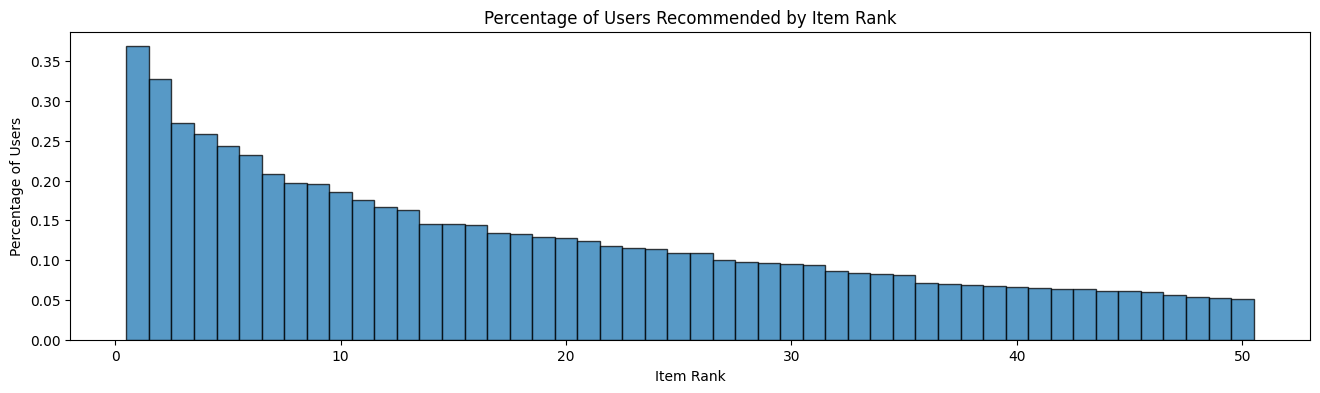

In [34]:
N = 50
fig, axes = plt.subplots(1, 1, figsize=[16, 4])

topN = recommendation_diversity.iloc[:N, :]
axes.bar(topN.index.values + 1, topN.pct_users, width=1, edgecolor='black', alpha=0.75)
axes.set(xlabel='Item Rank', ylabel='Percentage of Users', title='Percentage of Users Recommended by Item Rank')
plt.show()

### Calculate the Most Similar Items to a Given Item
* the model's representation of users/items in latent factor space allows for the calculation of item-item similarity with simple dot products
* in many contexts it's useful to serve similar items either for user acceptance or for contextual recommendations 
* one example might be recommending the user a list of movies to watch next after he/she has just finished watching a given movie

In [35]:
random_user = np.random.choice(interactions_valid.user_id.unique())
print("random user: {}".format(random_user))

random user: 2474


In [36]:
random_user_recs = valid_recommendations.loc[random_user]
random_user_recs = item_names[item_names.item_id.isin(random_user_recs)].set_index('item_id').loc[random_user_recs]
random_user_recs

,title,genres
item_id,,
593,"Silence of the Lambs, The (1991)",drama|thriller
1617,L.A. Confidential (1997),crime|film-noir|mystery|thriller
1214,Alien (1979),action|horror|sci-fi|thriller
296,Pulp Fiction (1994),crime|drama
110,Braveheart (1995),action|drama|war
1259,Stand by Me (1986),adventure|comedy|drama
3481,High Fidelity (2000),comedy
608,Fargo (1996),crime|drama|thriller
50,"Usual Suspects, The (1995)",crime|thriller


#### Look at Similar Movies for a Few of the User's Recommended Movies

In [37]:
most_similar_items = model.similar_items(919)
most_similar_items = item_names.set_index('item_id').loc[most_similar_items]
most_similar_items

,title,genres
item_id,,
1029,Dumbo (1941),animation|children's|musical
1282,Fantasia (1940),animation|children's|musical
594,Snow White and the Seven Dwarfs (1937),animation|children's|musical
2096,Sleeping Beauty (1959),animation|children's|musical
2080,Lady and the Tramp (1955),animation|children's|comedy|musical|romance
595,Beauty and the Beast (1991),animation|children's|musical
2087,Peter Pan (1953),animation|children's|fantasy|musical
914,My Fair Lady (1964),musical|romance
1945,On the Waterfront (1954),crime|drama


In [38]:
most_similar_items = model.similar_items(2028)
most_similar_items = item_names.set_index('item_id').loc[most_similar_items]
most_similar_items

,title,genres
item_id,,
527,Schindler's List (1993),drama|war
3753,"Patriot, The (2000)",action|drama|war
318,"Shawshank Redemption, The (1994)",drama
608,Fargo (1996),crime|drama|thriller
3148,"Cider House Rules, The (1999)",drama
1610,"Hunt for Red October, The (1990)",action|thriller
1233,"Boat, The (Das Boot) (1981)",action|drama|war
110,Braveheart (1995),action|drama|war
858,"Godfather, The (1972)",action|crime|drama


In [39]:
item_per_user = (df_train
                .groupby("user_id")["item_id"].count()
                .reset_index(name="total_item")).sort_values(by=["total_item"], ascending=False)